## Logistic Regression Model
Create and fit a logistic regression model on the USA World Series "diff" data, tune model parameters, then extract most important features of the data.

In [2]:
%matplotlib inline
#Import pandas, numpy and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning alogorithms and model tools
import sklearn
#from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

### Split training and test

In [3]:
#Import Data - only want USA matches
df = pd.read_csv('../data/output/final_diffs_all.csv')
df.head()

,Opp,Tournament,Poss_Time_Diff,Score_Diff,Conv_Diff,Tries_Diff,Passes_Diff,Contestable_KO_Win_pct_Diff,PenFK_Against_Diff,RuckMaul_Diff,Ruck_Win_pct_Diff,Cards_diff,Lineout_Win_Pct_Diff,Scrum_Win_Pct_Diff
0,AUSTRALIA,2015_Cape_Town,13.966480,-10.638298,-14.285714,0.250000,25.925926,-50.000000,0.000000,0.000000,0.083333,50.0,0.333333,1.0
1,WALES,2015_Cape_Town,7.471264,15.555556,14.285714,0.083333,27.868852,25.000000,-20.000000,-100.000000,0.250000,0.0,-1.000000,0.0
2,KENYA,2015_Cape_Town,-33.136095,-44.444444,-33.333333,-0.750000,-10.638298,-16.666667,66.666667,60.000000,-0.550000,0.0,-1.000000,0.0
3,NEW ZEALAND,2015_Cape_Town,51.758794,33.333333,33.333333,0.000000,76.119403,-75.000000,-50.000000,-100.000000,0.250000,0.0,0.000000,-1.0
4,FIJI,2015_Cape_Town,12.880562,-20.833333,-25.000000,0.266667,38.461538,-66.666667,-33.333333,-33.333333,0.208333,0.0,-1.000000,0.0


In [4]:
# Replace NaN's with zero
df.fillna(value=0, inplace=True)

In [5]:
# create result: win = 1, loss = 0
# if 'Score_Diff' is > 0 = win, if < 0, else tie
def createResult(x):
    if x > 0:
        return 1
    elif x < 0:
        return 0
    elif x == 0:
        return 2

df.loc[:,'Result'] = df.loc[:,'Score_Diff'].apply(createResult)

In [6]:
df.head()

,Opp,Tournament,Poss_Time_Diff,Score_Diff,Conv_Diff,Tries_Diff,Passes_Diff,Contestable_KO_Win_pct_Diff,PenFK_Against_Diff,RuckMaul_Diff,Ruck_Win_pct_Diff,Cards_diff,Lineout_Win_Pct_Diff,Scrum_Win_Pct_Diff,Result
0,AUSTRALIA,2015_Cape_Town,13.966480,-10.638298,-14.285714,0.250000,25.925926,-50.000000,0.000000,0.000000,0.083333,50.0,0.333333,1.0,0
1,WALES,2015_Cape_Town,7.471264,15.555556,14.285714,0.083333,27.868852,25.000000,-20.000000,-100.000000,0.250000,0.0,-1.000000,0.0,1
2,KENYA,2015_Cape_Town,-33.136095,-44.444444,-33.333333,-0.750000,-10.638298,-16.666667,66.666667,60.000000,-0.550000,0.0,-1.000000,0.0,0
3,NEW ZEALAND,2015_Cape_Town,51.758794,33.333333,33.333333,0.000000,76.119403,-75.000000,-50.000000,-100.000000,0.250000,0.0,0.000000,-1.0,1
4,FIJI,2015_Cape_Town,12.880562,-20.833333,-25.000000,0.266667,38.461538,-66.666667,-33.333333,-33.333333,0.208333,0.0,-1.000000,0.0,0


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
#Drop features that are unneccessary/str or will bias the prediction
rf_data = df.drop((['Opp', 'Score_Diff', 'Tries_Diff','Tournament', 'Conv_Diff']), axis=1)

#Drop rows with Result == "T" (Ties). This label messes up classification models, 
#and there are only a handful of ties
rf_data.drop(rf_data[rf_data.Result == 2].index, inplace=True)

#Pull out the variable we're trying to predict: 'Result'
X = rf_data.drop('Result',axis=1)
y = rf_data['Result']

In [9]:
rf_data.head()

,Poss_Time_Diff,Passes_Diff,Contestable_KO_Win_pct_Diff,PenFK_Against_Diff,RuckMaul_Diff,Ruck_Win_pct_Diff,Cards_diff,Lineout_Win_Pct_Diff,Scrum_Win_Pct_Diff,Result
0,13.966480,25.925926,-50.000000,0.000000,0.000000,0.083333,50.0,0.333333,1.0,0
1,7.471264,27.868852,25.000000,-20.000000,-100.000000,0.250000,0.0,-1.000000,0.0,1
2,-33.136095,-10.638298,-16.666667,66.666667,60.000000,-0.550000,0.0,-1.000000,0.0,0
3,51.758794,76.119403,-75.000000,-50.000000,-100.000000,0.250000,0.0,0.000000,-1.0,1
4,12.880562,38.461538,-66.666667,-33.333333,-33.333333,0.208333,0.0,-1.000000,0.0,0


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

### Scale the data

In [11]:
# Standardize data (0 mean, 1 stdev)
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print("Scaled training set Parameters \n")

print("Parameters from scaler model")
print(sc.get_params(deep=True))

Scaled training set Parameters 

Parameters from scaler model
{'copy': True, 'with_mean': True, 'with_std': True}


### Build & Train a Logistic Regression Model

In [12]:
#Initialize a Log Reg model and fit it
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [13]:
#Make predictions
y_pred = LogReg.predict(X_test)

In [14]:
# Create and print a confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[14,  2],
       [13, 20]])

In [15]:
#Create and print a classificiation report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.88      0.65        16
           1       0.91      0.61      0.73        33

   micro avg       0.69      0.69      0.69        49
   macro avg       0.71      0.74      0.69        49
weighted avg       0.78      0.69      0.70        49



In [16]:
# Use score method to get accuracy of model
score = LogReg.score(X_test, y_test)
print(score)

0.6938775510204082


### Model parameter tuning
The trade-off parameter of logistic regression that determines the strength of the regularization is called C, and higher values of C correspond to less regularization (where we can specify the regularization function). C is actually the Inverse of regularization strength(lambda)

In [17]:
######default C=1#####
print("training set score: %f" % LogReg.score(X_train, y_train))
print('\n'"test set score: %f" % LogReg.score(X_test, y_test))

training set score: 0.705357

test set score: 0.693878


In [18]:
######increase C to 100#####
lgr100=LogisticRegression(C=100).fit(X_train,y_train)
print('\n'"training set score of lgr100: %f" % lgr100.score(X_train, y_train))
print('\n'"test set score of lgr100: %f" % lgr100.score(X_test, y_test))


training set score of lgr100: 0.696429

test set score of lgr100: 0.673469


/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [19]:
 ######decrease C to 0.01#####
lgr001=LogisticRegression(C=0.01).fit(X_train,y_train)
print('\n'"training set score of lgr001: %f" % lgr001.score(X_train, y_train))
print('\n'"test set score of lgr001: %f" % lgr001.score(X_test, y_test))


training set score of lgr001: 0.642857

test set score of lgr001: 0.612245


/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [20]:
rf_data.columns.values

array(['Poss_Time_Diff', 'Passes_Diff', 'Contestable_KO_Win_pct_Diff',
       'PenFK_Against_Diff', 'RuckMaul_Diff', 'Ruck_Win_pct_Diff',
       'Cards_diff', 'Lineout_Win_Pct_Diff', 'Scrum_Win_Pct_Diff',
       'Result'], dtype=object)

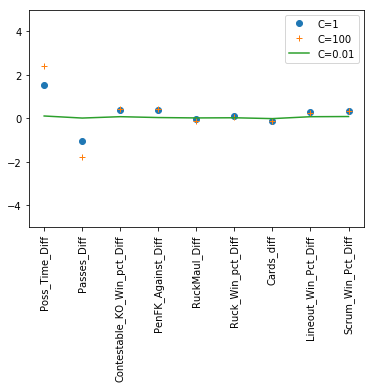

In [21]:
import matplotlib.pyplot as plt
plt.plot(LogReg.coef_.T,'o',label='C=1')
plt.plot(lgr100.coef_.T,'+',label='C=100')
plt.plot(lgr001.coef_.T,'-',label='C=0.01')
plt.xticks(range(X_train.shape[1]),rf_data.columns.values,rotation=90)
plt.ylim(-5,5)
plt.legend()
plt.show()

/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs


Training Accuracy of L1 LogReg with C=0.010000:0.482143

Test Accuracy of L1 LogReg with C=0.010000: 0.326531

Training Accuracy of L1 LogReg with C=0.100000:0.651786

Test Accuracy of L1 LogReg with C=0.100000: 0.530612

Training Accuracy of L1 LogReg with C=1.000000:0.705357

Test Accuracy of L1 LogReg with C=1.000000: 0.693878

Training Accuracy of L1 LogReg with C=10.000000:0.705357

Test Accuracy of L1 LogReg with C=10.000000: 0.673469

Training Accuracy of L1 LogReg with C=100.000000:0.696429

Test Accuracy of L1 LogReg with C=100.000000: 0.673469


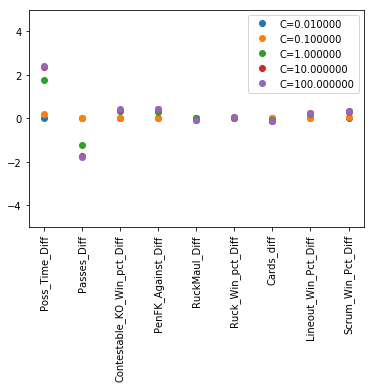

In [22]:
###If we desire a more interpretable model, using L1 regularization might help
###As LogisticRegression applies an L2 regularization by default, the result 
###looks similar to Ridge in Figure ridge_coefficients. Stronger regularization 
###pushes coefficients more and more towards zero, though coefficients never 
###become exactly zero.
 
import numpy as np
import math
n=np.arange(-2,3)
r=pow(float(10),n)
 
for C in r:
    lr_l1=LogisticRegression(C=C,penalty="l1").fit(X_train,y_train)
    print('\n'"Training Accuracy of L1 LogReg with C=%f:%f"%(C,lr_l1.score(X_train,y_train)))
    print('\n'"Test Accuracy of L1 LogReg with C=%f: %f"%(C,lr_l1.score(X_test,y_test)))
    plt.plot(lr_l1.coef_.T,'o',label="C=%f"%C)
plt.xticks(range(X_train.shape[1]),rf_data.columns.values,rotation=90)
plt.ylim(-5,5)
plt.legend(loc='best')
plt.show()

### Use GridSearch to find best C value

In [23]:
# Create hyperparameter search space

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [24]:
# Create grid search using 5-fold cross validation
clf = GridSearchCV(LogReg, hyperparameters, cv=5, verbose=0)

In [25]:
# Fit grid search
best_model = clf.fit(X, y)

/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

In [26]:
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 1.0


In [29]:
#Predict using best model
# Predict target vector
#best_pred_X = best_model.predict(X)
best_pred = best_model.predict(X)

In [30]:
print (best_model.best_estimator_)
print (best_model.score(X_test, y_test))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.5714285714285714


In [31]:
# Re-run LogReg model with best parameters
#Initialize a Log Reg model and fit it
LogReg = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
y_pred = LogReg.predict(X_test)

In [37]:
# Create and print a confusion matrix for the test set predictions
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[13,  3],
       [12, 21]])

In [34]:
#Create and print a classificiation report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.81      0.63        16
           1       0.88      0.64      0.74        33

   micro avg       0.69      0.69      0.69        49
   macro avg       0.70      0.72      0.69        49
weighted avg       0.76      0.69      0.70        49



The logistic regression classifier, after tuning the hyerparameters, had a higher precision, but lower recall, and an overall F1-score of .70 .

### Extract the most important features, in order of importance

In [35]:
coefs=LogReg.coef_[0]
top_five = np.argpartition(coefs, -5)[-5:]
top_five_sorted=top_five[np.argsort(coefs[top_five])]
impt_feat = rf_data.columns.values[top_five]
type(impt_feat)
print(impt_feat)

['Lineout_Win_Pct_Diff' 'Scrum_Win_Pct_Diff' 'PenFK_Against_Diff'
 'Contestable_KO_Win_pct_Diff' 'Poss_Time_Diff']


In [36]:
#print (np.apply_along_axis(myfunction, axis=0, arr=impt_feat))
#[36 66 96]